# Suffix vs Non-suffix Words

### Packages

In [20]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

from data_processing import DataGenerator
from model import GenderLSTM
from model_evaluation import baseline_accuracy, compare_accuracies, statistical_check
from visualization import plot_metrics

### Hyperparameters

In [21]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedding_dim = 128
hidden_size = 256
batch_size = 64
n_epochs = 20
lr = 0.001

### Datasets

In [22]:
nlexique = pd.read_csv('../data/nlexique.csv')
nlexique = nlexique[['lexeme', 'sg', 'gen']].rename(columns={'sg': 'phon'}).dropna().reset_index(drop=True)
nlexique

,lexeme,phon,gen
0,à-côté,akOte,m
1,à-coup,aku,m
2,à-peu-près,apØpʁɛ,m
3,à-pic,apik,m
4,à-plat,apla,m
...,...,...,...
30999,zurichois,zyʁikwa,m
31000,zydeco,zidəko,f
31001,zygoma,zigOma,m
31002,zygote,zigɔt,m


In [23]:
echantinom = pd.read_csv('../data/Echantinom-full-20210902.csv')
echantinom = echantinom[~echantinom['lemma'].isin(nlexique[nlexique['gen'] == 'b']['lexeme'])][['lemma', 'gen', 'phon', 'suffix']]
echantinom

,lemma,gen,phon,suffix
0,berlingue,m,bɛʁ.lɛ̃g,0
1,corton,m,kɔʁ.tɔ̃,on
2,dabuche,f,da.byʃ,uche
3,faf,m,faf,0
4,gail,f,gaj,0
...,...,...,...,...
4995,palu,m,pa.ly,0
4996,talc,m,talk,0
4997,sauvetage,m,sO.və.taʒ,age
4998,plaid,m,plɛd,0


In [24]:
echantinom = pd.merge(echantinom, nlexique, left_on='lemma', right_on='lexeme', how='left', suffixes=('_y', ''))\
           .drop(columns=['lexeme', 'phon_y', 'gen_y']).dropna().reset_index(drop=True)

echantinom

,lemma,suffix,phon,gen
0,berlingue,0,bɛʁlɛ̃g,m
1,corton,on,kɔʁtɔ̃,m
2,dabuche,uche,dabyʃ,f
3,faf,0,faf,m
4,gail,0,gaj,f
...,...,...,...,...
4527,palu,0,paly,m
4528,talc,0,talk,m
4529,sauvetage,age,sOvətaʒ,m
4530,plaid,0,plɛd,m


## Orthographic forms

In [25]:
orth_train = nlexique[(~nlexique['lexeme'].isin(echantinom['lemma'])) & (nlexique['gen'] != 'b')][['lexeme', 'gen']]
orth_train

,lexeme,gen
0,à-côté,m
1,à-coup,m
2,à-peu-près,m
3,à-pic,m
4,à-plat,m
...,...,...
30999,zurichois,m
31000,zydeco,f
31001,zygoma,m
31002,zygote,m


In [26]:
orth_test = echantinom[['lemma', 'gen']]
orth_test

,lemma,gen
0,berlingue,m
1,corton,m
2,dabuche,f
3,faf,m
4,gail,f
...,...,...
4527,palu,m
4528,talc,m
4529,sauvetage,m
4530,plaid,m


In [27]:
orth_train_set, orth_valid_set = train_test_split(orth_train, test_size=0.2)

orth_train_generator = DataGenerator(orth_train_set, reverse_nouns=True)
orth_valid_generator = DataGenerator(orth_valid_set, parentgenerator=orth_train_generator, reverse_nouns=True)

orth_model = GenderLSTM(orth_train_generator, embedding_dim, hidden_size, device=DEVICE, reversed=True)
orth_train_metrics, orth_valid_metrics = orth_model.train_model(
    orth_train_generator, orth_valid_generator, n_epochs, batch_size, lr, save_model='../saved_models/nlexique_orth_model.pth'
    )

Epoch: 0
[Train] Loss: 0.3700   Accuracy: 84.81%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 61.24%
[Valid] Loss: 0.4380   Accuracy: 79.19%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 65.98%
----------------------------------------------------------------------------------------------------
Epoch: 1
[Train] Loss: 0.2584   Accuracy: 89.55%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 64.73%
[Valid] Loss: 0.2721   Accuracy: 88.82%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 66.01%
----------------------------------------------------------------------------------------------------
Epoch: 2
[Train] Loss: 0.2259   Accuracy: 90.62%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 64.23%
[Valid] Loss: 0.2564   Accuracy: 89.58%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 65.93%
---------------------------------------------

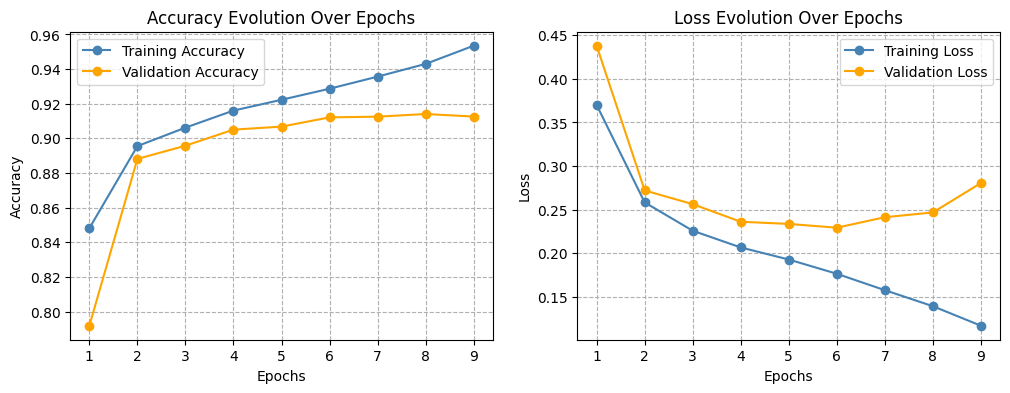

In [28]:
plot_metrics(orth_train_metrics['accuracy'], orth_valid_metrics['accuracy'], orth_train_metrics['loss'], orth_valid_metrics['loss'])

The most frequent label in the dataset is: m


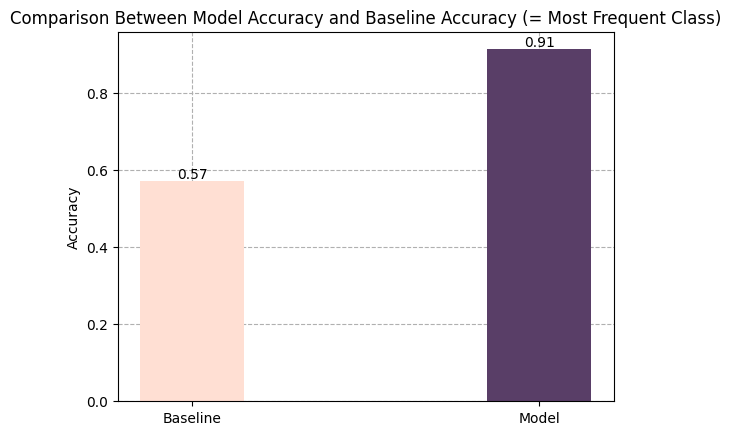

In [29]:
baseline_acc = baseline_accuracy(orth_train_generator, orth_valid_generator, verbose=True)

compare_accuracies(baseline_acc, orth_valid_metrics['accuracy'][-1])

In [30]:
orth_test_generator = DataGenerator(orth_test, parentgenerator=orth_train_generator, reverse_nouns=True)
orth_predictions = orth_model.predict(orth_test_generator, batch_size, set='test')
pd.DataFrame(orth_predictions).to_csv('../results/echantinom_orth_preds.csv', index=False)

## Phonetic forms

In [31]:
phon_train = nlexique[(~nlexique['lexeme'].isin(echantinom['lemma'])) & (nlexique['gen'] != 'b')][['phon', 'gen']]
phon_train

,phon,gen
0,akOte,m
1,aku,m
2,apØpʁɛ,m
3,apik,m
4,apla,m
...,...,...
30999,zyʁikwa,m
31000,zidəko,f
31001,zigOma,m
31002,zigɔt,m


In [32]:
phon_test = echantinom[['phon', 'gen']]
phon_test

,phon,gen
0,bɛʁlɛ̃g,m
1,kɔʁtɔ̃,m
2,dabyʃ,f
3,faf,m
4,gaj,f
...,...,...
4527,paly,m
4528,talk,m
4529,sOvətaʒ,m
4530,plɛd,m


In [33]:
phon_train_set, phon_valid_set = train_test_split(phon_train, test_size=0.2)

phon_train_generator = DataGenerator(phon_train_set, reverse_nouns=True)
phon_valid_generator = DataGenerator(phon_valid_set, parentgenerator=phon_train_generator, reverse_nouns=True)

phon_model = GenderLSTM(phon_train_generator, embedding_dim, hidden_size, device=DEVICE, reversed=True)
phon_train_metrics, phon_valid_metrics = phon_model.train_model(
    phon_train_generator, phon_valid_generator, n_epochs, batch_size, lr, save_model='../saved_models/nlexique_phon_model.pth'
    )

Epoch: 0
[Train] Loss: 0.4269   Accuracy: 79.12%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 56.79%
[Valid] Loss: 0.4215   Accuracy: 78.96%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 56.34%
----------------------------------------------------------------------------------------------------
Epoch: 1
[Train] Loss: 0.3626   Accuracy: 82.53%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 56.87%
[Valid] Loss: 0.4155   Accuracy: 78.91%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 58.65%
----------------------------------------------------------------------------------------------------
Epoch: 2
[Train] Loss: 0.3328   Accuracy: 84.43%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 57.51%
[Valid] Loss: 0.3849   Accuracy: 80.88%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 58.09%
---------------------------------------------

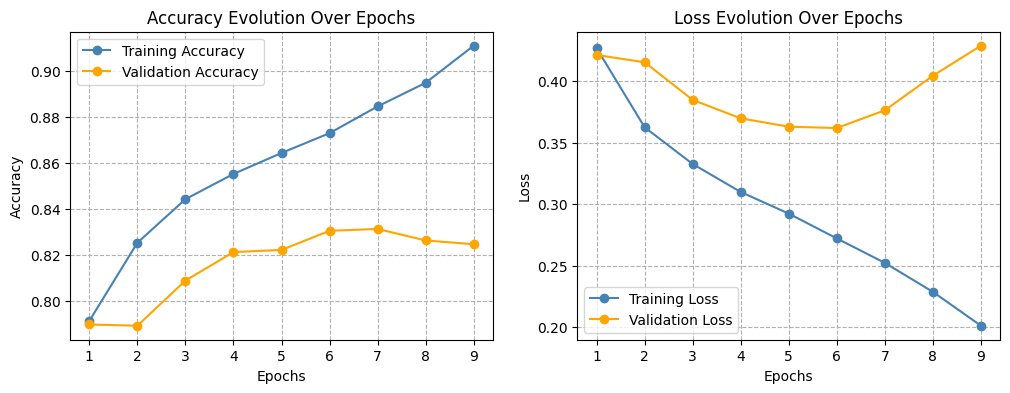

In [34]:
plot_metrics(phon_train_metrics['accuracy'], phon_valid_metrics['accuracy'], phon_train_metrics['loss'], phon_valid_metrics['loss'])

The most frequent label in the dataset is: m


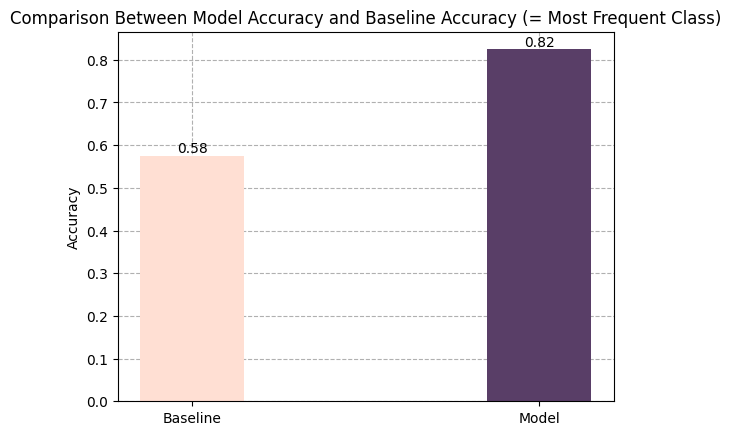

In [35]:
baseline_acc = baseline_accuracy(phon_train_generator, phon_valid_generator, verbose=True)

compare_accuracies(baseline_acc, phon_valid_metrics['accuracy'][-1])

In [36]:
phon_test_generator = DataGenerator(phon_test, parentgenerator=phon_train_generator, reverse_nouns=True)
phon_predictions = phon_model.predict(phon_test_generator, batch_size, set='test')
pd.DataFrame(phon_predictions).to_csv('../results/echantinom_phon_preds.csv', index=False)